[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-traditional/sparse_implementation.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/pinecone-io/examples/blob/master/learn/search/faiss-ebook/locality-sensitive-hashing-traditional/sparse_implementation.ipynb)

# Sparse Implementation of LSH

Locality Sensitive Hashing (LSH) can be implemented for both sparse and dense vectors. In this notebook we will implement the algorithm for searching sparse vectors. We will be using *k-shingling* and *minhashing* to create our sparse vectors before applying them for search with LSH.

We start by defining a few sentences.

In [1]:
a = "flying fish flew by the space station"
b = "he will not allow you to bring your sticks of dynamite and pet armadillo along"
c = "he figured a few sticks of dynamite were easier than a fishing pole to catch an armadillo"

The first thing we do is create our shingles, we will use k-shingles where `k == 2`. For longer text it is recommended to create shingles where it is unlikely to produce matching shingles between non-matching text, `k` values of `7` to `11` would likely produce this outcome.

In [2]:
k = 2
for i in range(len(a) - k+1):
    print(a[i: i+k], end='|')

fl|ly|yi|in|ng|g | f|fi|is|sh|h | f|fl|le|ew|w | b|by|y | t|th|he|e | s|sp|pa|ac|ce|e | s|st|ta|at|ti|io|on|

These are our shingles, however, we must remove duplicate values as we are producing a *set*. We do this using the Python type `set`. To apply shingling to each of our sentences we will define a `shingle` function:

In [3]:
def shingle(text: str, k: int):
    shingle_set = []
    for i in range(len(text) - k+1):
        shingle_set.append(text[i:i+k])
    return set(shingle_set)

In [4]:
a = shingle(a, k)
b = shingle(b, k)
c = shingle(c, k)
print(a)

{'ta', 'e ', 'y ', 'fi', 'ti', 'io', ' s', 'is', 'fl', 'sp', ' t', 'yi', 'by', 'ce', 'th', 'at', ' f', 'ly', ' b', 'g ', 'st', 'w ', 'sh', 'pa', 'ng', 'ac', 'h ', 'le', 'in', 'on', 'he', 'ew'}


Now that we have our three shingles we create a shingle vocabulary by create a `union` between all three sets.

In [5]:
vocab = list(a.union(b).union(c))
print(vocab)

['wi', 'te', 'ti', ' s', 're', 'et', 'ig', 'll', 'fl', 'it', 't ', 'ha', 'ce', 'th', ' f', 'po', 'ly', 'ca', 'sh', 'ck', 'nd', 'l ', ' c', ' n', ' d', 'br', 'il', 'le', 'ea', 'on', 'ie', 'ur', 'ta', 's ', 'ks', 'as', 'ed', 'io', 'ch', 'is', ' w', 'am', ' a', 'mi', ' t', 'u ', 'f ', 'yi', 'by', 'at', 'hi', 'yn', 'g ', 'lo', 'yo', 'w ', 'ow', ' y', 'h ', 'ic', 'an', 'rm', 'gu', 'ou', 'ad', 'of', 'y ', 'na', 'sp', 'di', 'ma', ' b', 'ri', 'we', 'a ', 'r ', 'he', 'ew', 'ol', 'fe', 'o ', 'e ', 'to', 'fi', 'al', 'no', 'd ', ' p', ' e', 'si', 'n ', 'tc', 'st', 'pe', 'ar', 'pa', 'ot', 'ng', 'ac', ' o', 'in', 'er', 'dy']


Using this vocab we can create one-hot encoded sparse vectors to represent our shingles.

In [6]:
a_1hot = [1 if x in a else 0 for x in vocab]
b_1hot = [1 if x in b else 0 for x in vocab]
c_1hot = [1 if x in c else 0 for x in vocab]
print(a_1hot)

[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]


So we now have one-hot encoded sparse vectors we can move onto *minhashing*.

## Minhashing

Minhashing is the next step in our process. After creating our shingle sets we use minhashing to create *signatures* from those sets.

To create our minhashing function we build several hash functions, each will randomly count from `1` to `len(vocab) + 1` - creating a *random* vector:

In [7]:
hash_ex = list(range(1, len(vocab)+1))
print(hash_ex)  # we haven't shuffled yet

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103]


In [8]:
from random import shuffle

shuffle(hash_ex)
print(hash_ex)

[93, 6, 56, 97, 88, 82, 90, 29, 22, 11, 44, 26, 41, 77, 17, 33, 65, 13, 69, 66, 45, 18, 36, 71, 85, 95, 37, 57, 40, 96, 19, 100, 87, 25, 16, 94, 81, 70, 46, 58, 21, 7, 102, 101, 10, 78, 3, 60, 27, 32, 24, 28, 14, 98, 59, 103, 73, 51, 67, 54, 8, 49, 34, 31, 47, 79, 30, 52, 9, 12, 23, 92, 61, 74, 5, 63, 38, 64, 83, 91, 80, 43, 53, 62, 75, 72, 86, 76, 4, 99, 2, 1, 39, 50, 89, 20, 55, 84, 42, 68, 35, 15, 48]


We now have a randomized list of integers which we can use in creating our *hashed* signatures. What we do now is begin counting from `1` through to `len(vocab) + 1`, extracting the position of this number in our new `hash_ex` list, like so (for the first few integers):

In [9]:
for i in range(1, 5):
    print(f"{i} -> {hash_ex.index(i)}")

1 -> 91
2 -> 90
3 -> 46
4 -> 88


What we do with this is count up from `1` to `len(vocab) + 1` and find if the resultant `hash_ex.index(i)` position in our one-hot encoded vectors contains a positive value (`1`) in that position, like so:

In [10]:
for i in range(1, len(vocab)+1):
    idx = hash_ex.index(i)
    signature_val = a_1hot[idx]
    print(f"{i} -> {idx} -> {signature_val}")
    if signature_val == 1:
        print('match!')
        break

1 -> 91 -> 0
2 -> 90 -> 0
3 -> 46 -> 0
4 -> 88 -> 0
5 -> 74 -> 0
6 -> 1 -> 0
7 -> 41 -> 0
8 -> 60 -> 0
9 -> 68 -> 1
match!


That gives us a first signature value of `98`. But this is just a single value, and it takes many values to create a signature (100 for example).

So, how to we generate these other values? By using more hash functions! Let's generate a set of hash functions to create a signature vector of length `20`.

hash_funcs = []

for _ in range(20)

In [11]:
hash_funcs = []

for _ in range(20):
    hash_ex = list(range(1, len(vocab)+1))
    shuffle(hash_ex)
    hash_funcs.append(hash_ex)

for i in range(3):
    print(f"hash function {i+1}:")
    print(hash_funcs[i])

hash function 1:
[58, 1, 48, 36, 34, 97, 66, 102, 65, 77, 78, 103, 95, 46, 79, 94, 37, 61, 83, 93, 69, 55, 16, 13, 50, 29, 11, 89, 27, 62, 68, 35, 72, 42, 17, 52, 24, 63, 26, 84, 51, 21, 54, 10, 25, 41, 88, 49, 64, 40, 30, 4, 56, 67, 23, 101, 71, 82, 43, 47, 53, 91, 15, 32, 70, 98, 2, 74, 76, 85, 22, 99, 6, 100, 87, 19, 18, 60, 45, 59, 86, 92, 75, 44, 33, 9, 73, 90, 7, 3, 31, 39, 80, 96, 81, 5, 57, 8, 12, 28, 14, 38, 20]
hash function 2:
[67, 100, 54, 52, 45, 101, 29, 49, 56, 73, 64, 13, 21, 40, 14, 95, 23, 5, 44, 96, 98, 4, 19, 91, 97, 103, 33, 92, 1, 15, 2, 77, 18, 66, 80, 24, 82, 9, 22, 6, 78, 70, 46, 31, 81, 43, 30, 48, 93, 61, 62, 63, 83, 20, 35, 32, 85, 47, 42, 69, 3, 68, 53, 76, 74, 60, 10, 58, 36, 8, 17, 79, 57, 12, 16, 41, 28, 65, 86, 71, 89, 37, 102, 34, 50, 84, 75, 26, 38, 27, 55, 39, 7, 25, 87, 11, 88, 51, 99, 90, 72, 59, 94]
hash function 3:
[21, 62, 67, 71, 12, 54, 46, 3, 83, 103, 38, 47, 6, 89, 20, 13, 85, 100, 58, 39, 18, 52, 30, 65, 24, 84, 101, 5, 79, 16, 2, 43, 70, 5

We're only showing the first three hash functions here - we have *20* in total. To create our signatures we simply process each one-hot vector through each hash function, appending the output value to our signature for that vector.

In [12]:
signature = []

for func in hash_funcs:
    for i in range(1, len(vocab)+1):
        idx = func.index(i)
        signature_val = a_1hot[idx]
        if signature_val == 1:
            signature.append(idx)
            break

print(signature)

[66, 39, 49, 76, 76, 66, 48, 66, 37, 81, 52, 81, 77, 3, 12, 13, 76, 48, 76, 95]


And there we have our minhash produced signature for `a`. Let's clean up the code and formalize the process a little.

In [13]:
def create_hash_func(size: int):
    # function for creating the hash vector/function
    hash_ex = list(range(1, size+1))
    shuffle(hash_ex)
    return hash_ex

def build_minhash_func(vocab_size: int, nbits: int):
    # function for building multiple minhash vectors
    hashes = []
    for _ in range(nbits):
        hashes.append(create_hash_func(vocab_size))
    return hashes

# we create 20 minhash vectors
minhash_func = build_minhash_func(len(vocab), 20)

In [14]:
def create_hash(vector: list):
    # use this function for creating our signatures (eg the matching)
    signature = []
    for func in minhash_func:
        for i in range(1, len(vocab)+1):
            idx = func.index(i)
            signature_val = vector[idx]
            if signature_val == 1:
                signature.append(idx)
                break
    return signature

In [15]:
# now create signatures
a_sig = create_hash(a_1hot)
b_sig = create_hash(b_1hot)
c_sig = create_hash(c_1hot)

print(a_sig)
print(b_sig)

[77, 100, 100, 55, 29, 16, 68, 97, 92, 48, 18, 32, 12, 18, 32, 77, 68, 49, 81, 14]
[42, 43, 69, 55, 29, 96, 86, 46, 92, 5, 72, 65, 29, 5, 53, 33, 40, 94, 96, 70]


We now have our three minhashed signatures! These signatures, despite being seemingly randomized, will on average have the very similar Jaccard similarity values as our previous sparse vectors. We have reduced the dimensionality of our vectors significantly - but maintained the same information!


In [16]:
def jaccard(a: set, b: set):
    return len(a.intersection(b)) / len(a.union(b))

**a** should have lower similarity with **b** and **c**:

In [17]:
jaccard(a, b), jaccard(set(a_sig), set(b_sig))

(0.14814814814814814, 0.10344827586206896)

In [18]:
jaccard(a, c), jaccard(set(a_sig), set(c_sig))

(0.22093023255813954, 0.13793103448275862)

And **b** and **c** should share much greater simliarity:

In [19]:
jaccard(b, c), jaccard(set(b_sig), set(c_sig))

(0.45652173913043476, 0.34615384615384615)

We're now ready to move onto the LSH process.

# Locality Sensitive Hashing

The approach we will be taking in this notebook is break our signature vector into multiple *bands*, creating several sub-vectors.

We then hash each of these sub-vectors into a set of buckets, if we find that two sub-vectors from two signature vectors collide (end up in the same hash bucket) we take the two *full* signature vectors as *candidate pairs* - which we then compare in full with a similarity metric (like Jaccard similarity, cosine similarity, etc).

There is no *'set'* way to hash our signature vectors, and in-fact the simplest approach is to check for equivalence across sub-vectors, which will be our approach.

First, we must define the number of buckets `b` we would like to create. It's important to note that each bucket must contain an equal number of rows `r` - and so our signature length must be divisible by `b`.

In [52]:
def split_vector(signature, b):
    assert len(signature) % b == 0
    r = int(len(signature) / b)
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, len(signature), r):
        subvecs.append(signature[i : i+r])
    return subvecs

We'll start by splitting into 10 bands, creating rows of `2` - on the small side to be used in a genuine LSH function but good for our example (we'll explore different `r` and `b` values soon).

Let's start with our **b** and **c** vectors, which should *hopefully* match in *at least one* band.

In [56]:
band_b = split_vector(b_sig, 10)
band_b

[[42, 43],
 [69, 55],
 [29, 96],
 [86, 46],
 [92, 5],
 [72, 65],
 [29, 5],
 [53, 33],
 [40, 94],
 [96, 70]]

In [57]:
band_c = split_vector(c_sig, 10)
band_c

[[90, 43],
 [69, 55],
 [4, 101],
 [35, 15],
 [92, 22],
 [18, 65],
 [40, 18],
 [53, 33],
 [40, 94],
 [80, 14]]

Check if they match (we'll rewrite some of this into Numpy soon).

In [59]:
for b_rows, c_rows in zip(band_b, band_c):
    if b_rows == c_rows:
        print(f"Candidate pair: {b_rows} == {c_rows}")
        # we only need one band to match
        break

Candidate pair: [69, 55] == [69, 55]


And let's do the same for **a**.

In [60]:
band_a = split_vector(a_sig, 10)

In [61]:
for a_rows, b_rows in zip(band_a, band_b):
    if a_rows == b_rows:
        print(f"Candidate pair: {a_rows} == {b_rows}")
        # we only need one band to match
        break

In [62]:
for a_rows, c_rows in zip(band_a, band_c):
    if a_rows == c_rows:
        print(f"Candidate pair: {b_rows} == {c_rows}")
        # we only need one band to match
        break

Okay great, so even with this very simple implementation - we manage to identify sentences **b** and **c** and candidate pairs, and identify **a** as a non-candidate.

## Tuning LSH

We can visualize the probability of returning a candidate pair vs the similarity of the pair for different values of `r` and `b` (rows and bands respectively) like so:

In [20]:
def probability(s, r, b):
    # s: similarity
    # r: rows (per band)
    # b: number of bands
    return 1 - (1 - s**r)**b

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
results = pd.DataFrame({
    's': [],
    'P': [],
    'r,b': []
})

for s in np.arange(0.01, 1, 0.01):
    total = 100
    for b in [100, 50, 25, 20, 10, 5, 4, 2, 1]:
        r = int(total/b)
        P = probability(s, r, b)
        results = results.append({
            's': s,
            'P': P,
            'r,b': f"{r},{b}"
        }, ignore_index=True)

<AxesSubplot:xlabel='s', ylabel='P'>

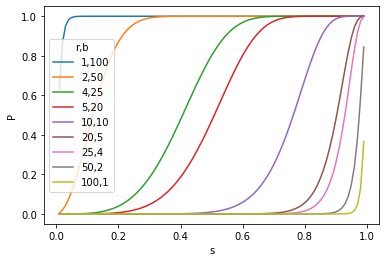

In [47]:
sns.lineplot(data=results, x='s', y='P', hue='r,b')